# Some integration tests for ARMA processes

In [1]:
%matplotlib inline
import time
import timeit
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from types import SimpleNamespace
from typing import Sequence, Callable
from tqdm.notebook import tqdm

from bioslds.arma import Arma, make_random_arma
from bioslds import sources
from bioslds.plotting import FigureManager

## Simulate a damped harmonic oscillator with no noise

We want to simulation
$$\ddot x = -\omega^2 x - \beta \dot x\,.$$
Discretizing, this reads
$$\frac {x(t+1) - 2 x(t) + x(t-1)} {2} = -\omega^2 x(t) - \beta \frac {x(t+1) - x(t-1)} {2}\,,$$
yielding
$$(1 + \beta) x(t+1) = 2x(t) - x(t-1) - 2 \omega^2 x(t) + \beta x(t-1)\,,$$
or
$$x(t+1) = \frac {2 (1 - \omega^2)} {1 + \beta} x(t) + (\beta - 1) x(t-1)\,.$$

In [2]:
dho_params = SimpleNamespace(period=15, beta=0.05, n=250)
dho_params.omega = 2 * np.pi / dho_params.period
dho_arma = Arma(
    [2 * (1 - dho_params.omega ** 2) / (1 + dho_params.beta), dho_params.beta - 1],
    [],
    default_source=sources.Constant(0),
    initial_conditions=([1.0, 1.0], []),
)

dho_signal, _ = dho_arma.transform(dho_params.n)

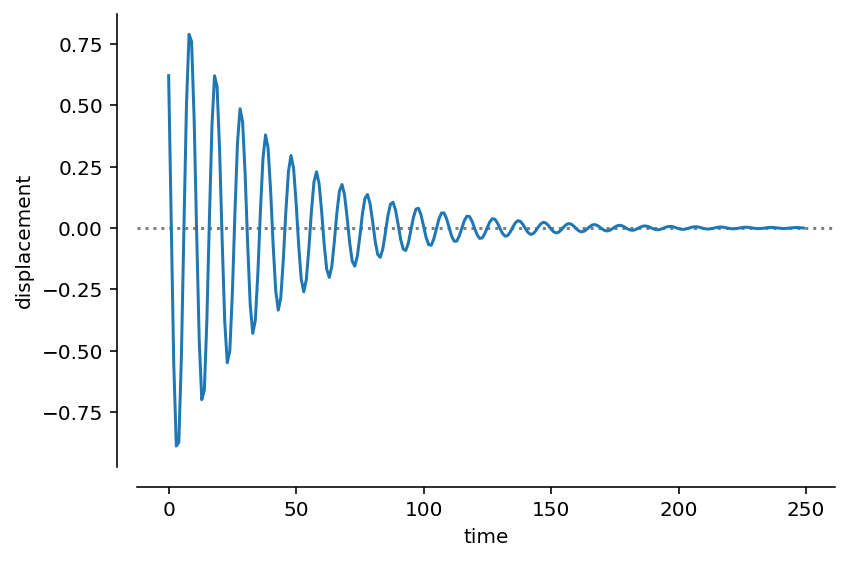

In [3]:
with FigureManager() as (_, ax):
    ax.axhline(0, ls=":", c="gray")
    ax.plot(dho_signal)
    ax.set_xlabel("time")
    ax.set_ylabel("displacement")

## Simulate the oscillator with noise

In [4]:
noisy_dho_params = SimpleNamespace(period=20, beta=0.05, n=250, sigma=0.02)
noisy_dho_params.omega = 2 * np.pi / dho_params.period
noisy_dho_arma = Arma(
    [
        2 * (1 - noisy_dho_params.omega ** 2) / (1 + noisy_dho_params.beta),
        noisy_dho_params.beta - 1,
    ],
    [],
    default_source=sources.GaussianNoise(
        np.random.default_rng(1), scale=noisy_dho_params.sigma
    ),
    initial_conditions=([1.0, 1.0], []),
)

noisy_dho_signal, _ = noisy_dho_arma.transform(noisy_dho_params.n)

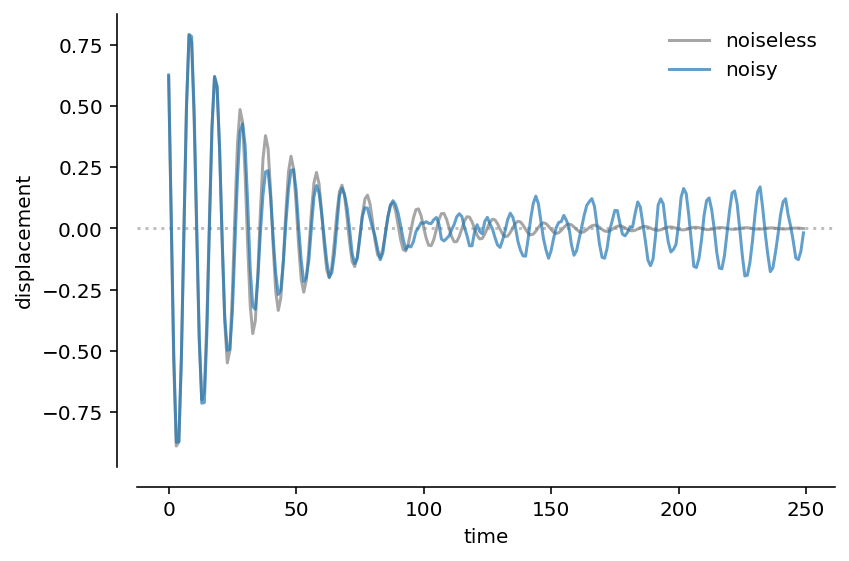

In [5]:
with FigureManager() as (_, ax):
    ax.axhline(0, ls=":", c="gray", alpha=0.5)
    ax.plot(dho_signal, c="gray", label="noiseless", alpha=0.7)
    ax.plot(noisy_dho_signal, label="noisy", alpha=0.7)
    ax.legend(frameon=False)
    ax.set_xlabel("time")
    ax.set_ylabel("displacement")

## Look at asymptotic distribution for noisy system

In [6]:
noisy_asymp_params = SimpleNamespace(n=10000)
noisy_asymp_arma = Arma(
    [1.5, -0.95],
    [0.2, 0.3],
    default_source=sources.GaussianNoise(np.random.default_rng(1)),
)

noisy_asymp_signal, _ = noisy_asymp_arma.transform(noisy_asymp_params.n)

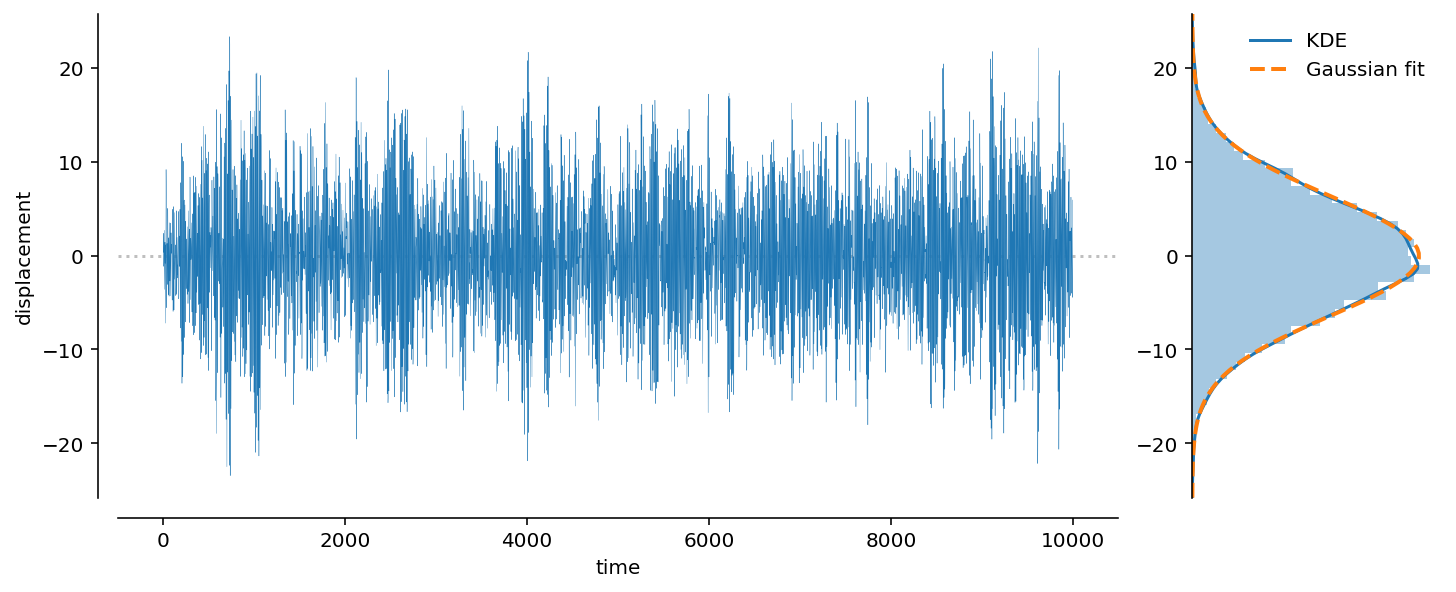

In [7]:
fig = plt.figure(figsize=(10, 4), constrained_layout=True)
gs = fig.add_gridspec(1, 5)
ax = fig.add_subplot(gs[0, :4])
ax_hist = fig.add_subplot(gs[0, 4])
ax.axhline(0, ls=":", c="gray", alpha=0.5)
ax.plot(noisy_asymp_signal, lw=0.2)
ax.set_xlabel("time")
ax.set_ylabel("displacement")

noisy_asymp_ylim = np.max(np.abs(ax.get_ylim()))
ax.set_ylim(-noisy_asymp_ylim, noisy_asymp_ylim)

sns.distplot(
    noisy_asymp_signal, vertical=True, kde_kws={"label": "KDE"}, ax=ax_hist,
)
ax_hist.set_xticks([])
ax_hist.set_ylim(-noisy_asymp_ylim, noisy_asymp_ylim)

# fit a Gaussian
noisy_asymp_mean = np.mean(noisy_asymp_signal)
noisy_asymp_std = np.std(noisy_asymp_signal)
noisy_asymp_fit_x = np.linspace(-noisy_asymp_ylim, noisy_asymp_ylim, 100)
noisy_asymp_fit_scale = 1 / np.sqrt(2 * np.pi * noisy_asymp_std ** 2)
noisy_asymp_fit_y = noisy_asymp_fit_scale * np.exp(
    -0.5 * ((noisy_asymp_fit_x - noisy_asymp_mean) / noisy_asymp_std) ** 2
)
ax_hist.plot(noisy_asymp_fit_y, noisy_asymp_fit_x, ls="--", lw=2, label="Gaussian fit")
ax_hist.legend(frameon=False)

sns.despine(ax=ax, offset=10)
sns.despine(ax=ax_hist, bottom=True)

## Check `sources.GaussianNoise` location and scale parameters

In [8]:
src_test_params = SimpleNamespace(loc=1.2, scale=3.2, n=10000)
src_test_generator = sources.GaussianNoise(
    np.random.default_rng(2), src_test_params.loc, src_test_params.scale
)
src_test_data = src_test_generator(size=src_test_params.n)

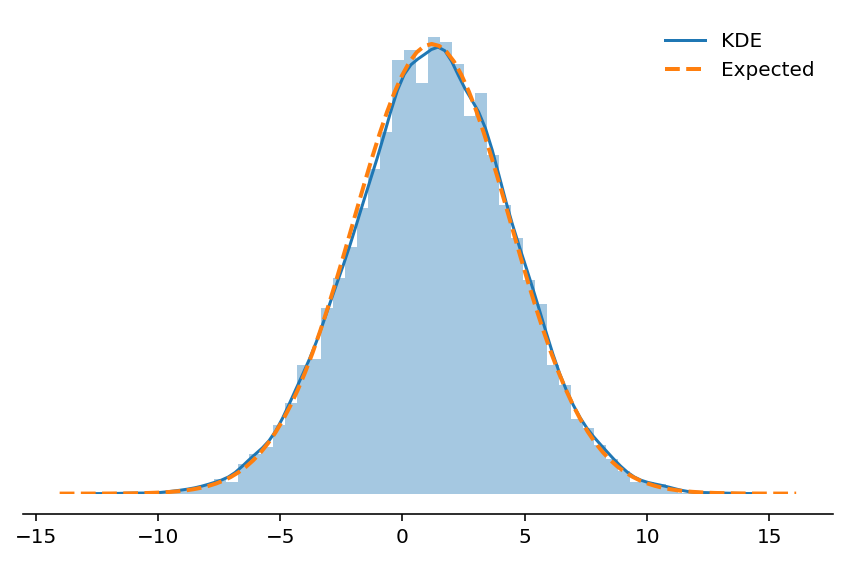

In [9]:
with FigureManager(despine_kws={"left": True}) as (_, ax):
    sns.distplot(
        src_test_data, kde_kws={"label": "KDE"}, ax=ax,
    )

    ax.set_yticks([])

    # show the expected Gaussian
    src_test_exp_x = np.linspace(*ax.get_xlim(), 100)
    src_test_exp_scale = 1 / np.sqrt(2 * np.pi * src_test_params.scale ** 2)
    src_test_exp_y = src_test_exp_scale * np.exp(
        -0.5 * ((src_test_exp_x - src_test_params.loc) / src_test_params.scale) ** 2
    )
    ax.plot(src_test_exp_x, src_test_exp_y, ls="--", lw=2, label="Expected")

    ax.legend(frameon=False)

## Test `fix_source_scale`

In [10]:
fix_scale_params = SimpleNamespace(seed_arma=5, seed_noise=10, p=4, q=3, n=10000)

rng = np.random.default_rng(fix_scale_params.seed_arma)
fix_scale_src = sources.GaussianNoise(
    np.random.default_rng(fix_scale_params.seed_noise)
)
fix_scale_arma_raw = make_random_arma(
    fix_scale_params.p, fix_scale_params.q, rng, default_source=fix_scale_src
)
# check output variance without fix_source_scale
fix_scale_std_raw = np.std(fix_scale_arma_raw.transform(fix_scale_params.n)[0])

print(f"Output variance without fix_source_scale: {fix_scale_std_raw:.4}.")

# now again
rng = np.random.default_rng(fix_scale_params.seed_arma)
fix_scale_src = sources.GaussianNoise(
    np.random.default_rng(fix_scale_params.seed_noise)
)
fix_scale_arma_fixed = make_random_arma(
    fix_scale_params.p, fix_scale_params.q, rng, default_source=fix_scale_src
)

t0 = time.time()
sources.fix_source_scale(fix_scale_arma_fixed, n_samples=10000)
t1 = time.time()

# check output variance without fix_source_scale
fix_scale_signal_fixed = fix_scale_arma_fixed.transform(fix_scale_params.n)[0]
fix_scale_std_fixed = np.std(fix_scale_signal_fixed)

print(f"Output variance with fix_source_scale: {fix_scale_std_fixed:.4}.    (fix_source_scale took {t1 - t0:.2} seconds)")

Output variance without fix_source_scale: 5.098.
Output variance with fix_source_scale: 1.01.    (fix_source_scale took 1.9 seconds)


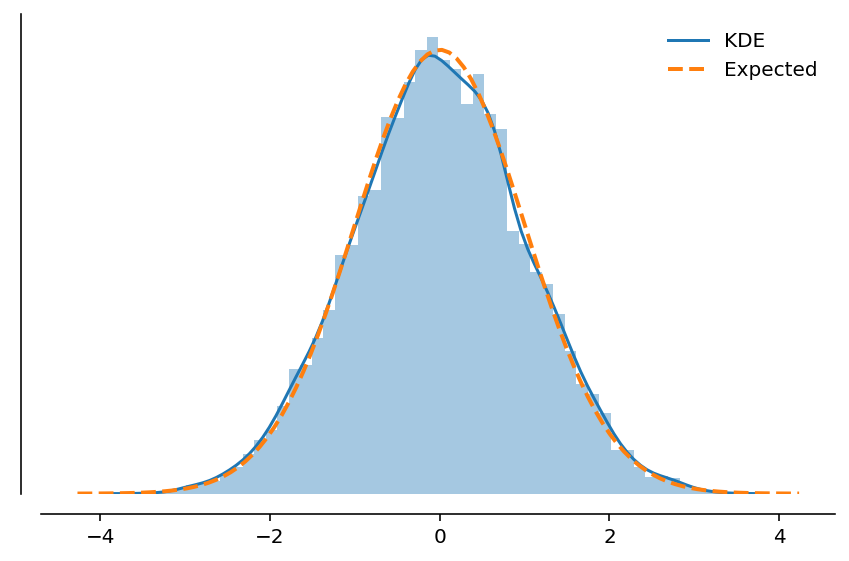

In [11]:
with FigureManager() as (_, ax):
    sns.distplot(
        fix_scale_signal_fixed, kde_kws={"label": "KDE"}, ax=ax,
    )

    ax.set_yticks([])

    # show the expected Gaussian
    fix_scale_exp_x = np.linspace(*ax.get_xlim(), 100)
    fix_scale_exp_scale = 1 / np.sqrt(2 * np.pi)
    fix_scale_exp_y = fix_scale_exp_scale * np.exp(-0.5 * fix_scale_exp_x ** 2)
    ax.plot(fix_scale_exp_x, fix_scale_exp_y, ls="--", lw=2, label="Expected")

    ax.legend(frameon=False)

## Check distribution of poles and zeros in random ARMAs

### Default radius

In [12]:
rng = np.random.default_rng(41)
arma_dist_params = SimpleNamespace(p=6, q=6, n=1000)
arma_dist_armas = [
    make_random_arma(arma_dist_params.p, arma_dist_params.q, rng)
    for _ in range(arma_dist_params.n)
]
arma_dist_poles = np.hstack([_.calculate_poles() for _ in arma_dist_armas])
arma_dist_zeros = np.hstack([_.calculate_zeros() for _ in arma_dist_armas])

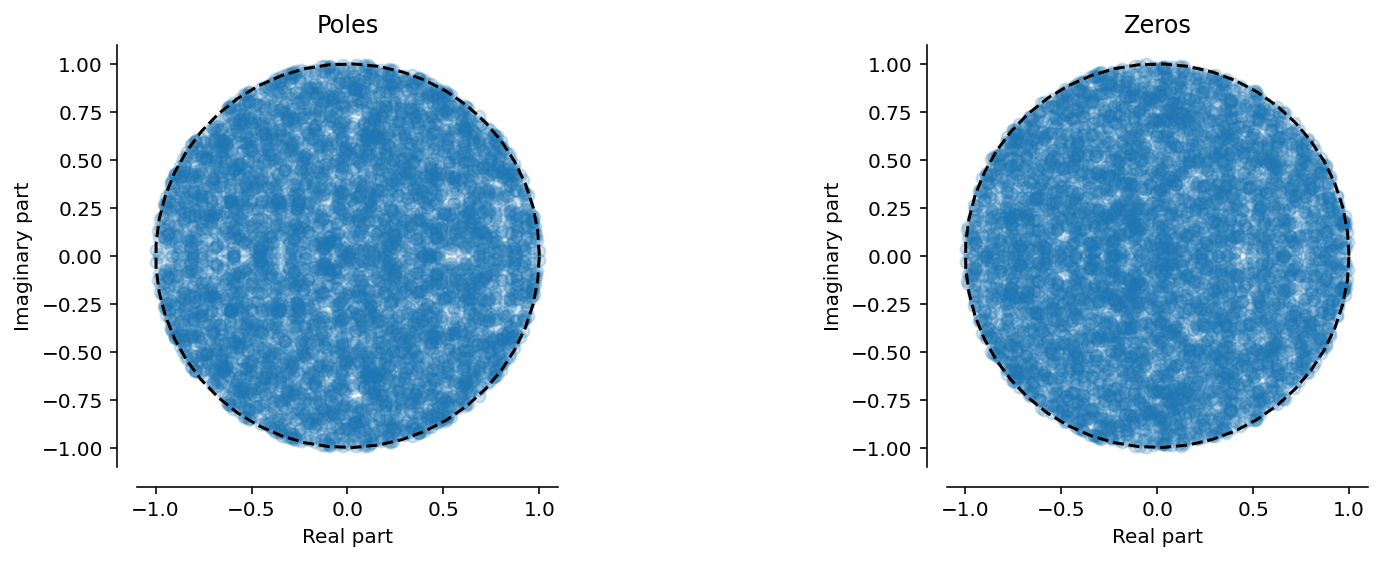

In [13]:
with FigureManager(1, 2) as (_, (ax1, ax2)):
    ax1.scatter(np.real(arma_dist_poles), np.imag(arma_dist_poles), alpha=0.2)
    
    crt_angle = np.linspace(0, 2 * np.pi, 50)
    crt_x = np.cos(crt_angle)
    crt_y = np.sin(crt_angle)
    ax1.plot(crt_x, crt_y, "--k")
    ax1.set_aspect(1)
    ax1.set_xlabel("Real part")
    ax1.set_ylabel("Imaginary part")
    ax1.set_title("Poles")
    
    ax2.scatter(np.real(arma_dist_zeros), np.imag(arma_dist_zeros), alpha=0.2)
    ax2.plot(crt_x, crt_y, "--k")
    ax2.set_aspect(1)
    ax2.set_xlabel("Real part")
    ax2.set_ylabel("Imaginary part")
    ax2.set_title("Zeros")

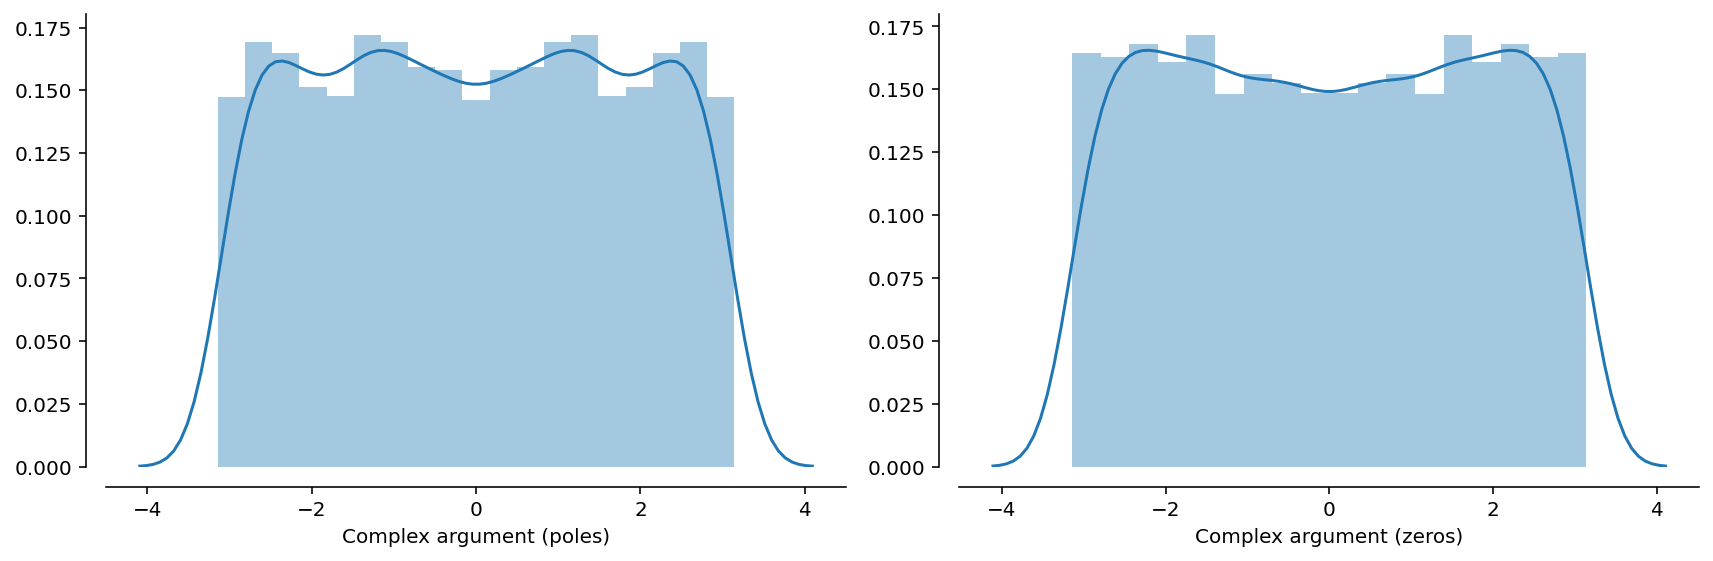

In [14]:
with FigureManager(1, 2) as (_, (ax1, ax2)):
    sns.distplot(np.angle(arma_dist_poles), ax=ax1)
    sns.distplot(np.angle(arma_dist_zeros), ax=ax2)
    
    ax1.set_xlabel("Complex argument (poles)")
    ax2.set_xlabel("Complex argument (zeros)")

### Choosing maximum radius

In [15]:
rng = np.random.default_rng(42)
arma_dist2_params = SimpleNamespace(p=6, q=6, n=1000, pole_radius=0.5, zero_radius=1.3)
arma_dist2_armas = [
    make_random_arma(
        arma_dist2_params.p,
        arma_dist2_params.q,
        rng,
        max_pole_radius=arma_dist2_params.pole_radius,
        max_zero_radius=arma_dist2_params.zero_radius,
    )
    for _ in range(arma_dist2_params.n)
]
arma_dist2_poles = np.hstack([_.calculate_poles() for _ in arma_dist2_armas])
arma_dist2_zeros = np.hstack([_.calculate_zeros() for _ in arma_dist2_armas])

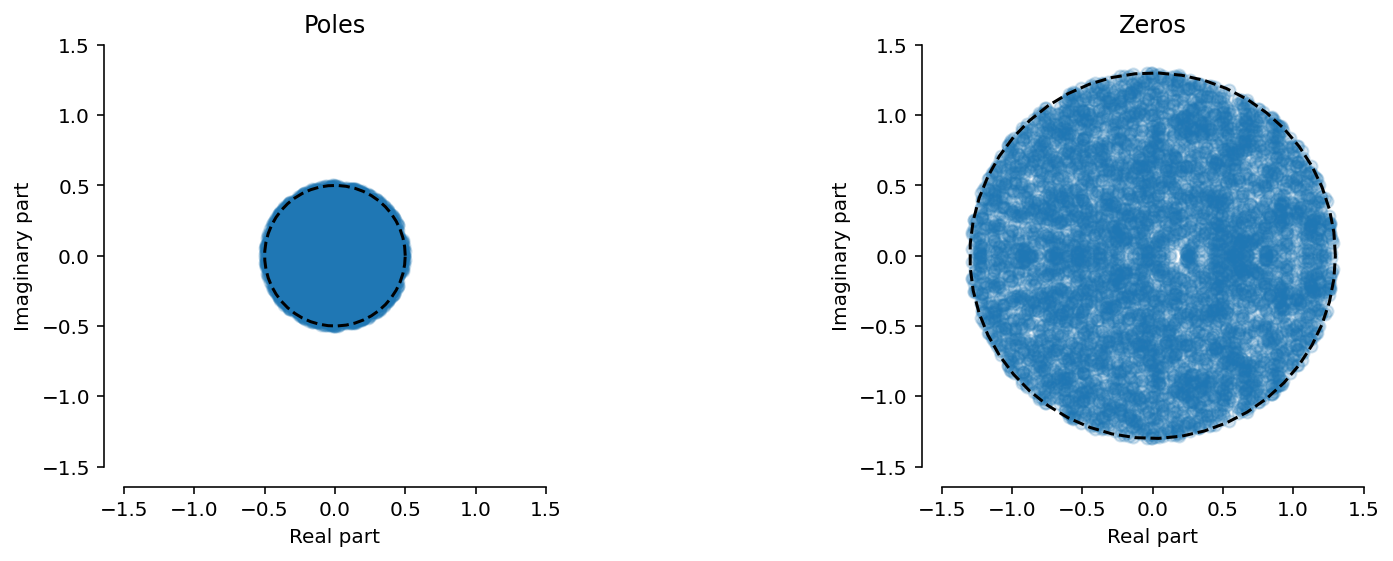

In [16]:
with FigureManager(1, 2) as (_, (ax1, ax2)):
    ax1.scatter(np.real(arma_dist2_poles), np.imag(arma_dist2_poles), alpha=0.2)

    crt_angle = np.linspace(0, 2 * np.pi, 50)
    crt_x = arma_dist2_params.pole_radius * np.cos(crt_angle)
    crt_y = arma_dist2_params.pole_radius * np.sin(crt_angle)
    ax1.plot(crt_x, crt_y, "--k")
    ax1.set_xlim(-1.5, 1.5)
    ax1.set_ylim(-1.5, 1.5)
    ax1.set_aspect(1)
    ax1.set_xlabel("Real part")
    ax1.set_ylabel("Imaginary part")
    ax1.set_title("Poles")

    ax2.scatter(np.real(arma_dist2_zeros), np.imag(arma_dist2_zeros), alpha=0.2)
    crt_x = arma_dist2_params.zero_radius * np.cos(crt_angle)
    crt_y = arma_dist2_params.zero_radius * np.sin(crt_angle)
    ax2.plot(crt_x, crt_y, "--k")
    ax2.set_xlim(-1.5, 1.5)
    ax2.set_ylim(-1.5, 1.5)
    ax2.set_aspect(1)
    ax2.set_xlabel("Real part")
    ax2.set_ylabel("Imaginary part")
    ax2.set_title("Zeros")

## Benchmark `Arma.transform` speed

In [17]:
def benchmark_arma(arma: Arma, sample_sizes: Sequence, progress: Callable = None):
    """ Benchmark speed of `Arma.transform`.
    
    This runs `Arma.transform` for different sample sizes, benchmarking the
    execution speed.
    
    Parameters
    ----------
    arma
        Arma process to benchmark. This should have a `default_source`.
    sample_sizes
        Sequence indicating which sample sizes to use.
    progress
        Callable to track progress.
    
    Returns a tuple of arrays, `(sample_sizes, times)`, with the first
    element, `sample_sizes`, simply a clone of the input argument, and the
    second element, `times`, indicating the times (in seconds) it took to
    transform each of the data sets with sizes given by `sample_siezs`. The
    timings are obtained by potentially running the task many times, using
    the `autorange` member from `timeit.Timer`.
    """
    times = np.zeros(len(sample_sizes))
    if progress is None:
        progress = lambda it: it
    for i, n in enumerate(progress(sample_sizes)):
        timer = timeit.Timer(lambda: arma.transform(n))
        count, total_time = timer.autorange()

        times[i] = total_time / count

    return sample_sizes, times

In [18]:
spd_params = SimpleNamespace(
    orders=[(1, 1), (5, 5), (10, 10)],
    sample_sizes=np.geomspace(10, 100000, 20).astype(int),
)

spd_results = {}
spd_all_modes = Arma._available_modes
for crt_mode in spd_all_modes:
    for crt_order in spd_params.orders:
        crt_arma = make_random_arma(
            *crt_order, np.random.default_rng(10), default_source=sources.GaussianNoise(3)
        )
        crt_sizes, crt_times = benchmark_arma(
            crt_arma, spd_params.sample_sizes, progress=tqdm
        )

        spd_results[crt_mode, crt_order] = {"arma": crt_arma, "sizes": crt_sizes, "times": crt_times}

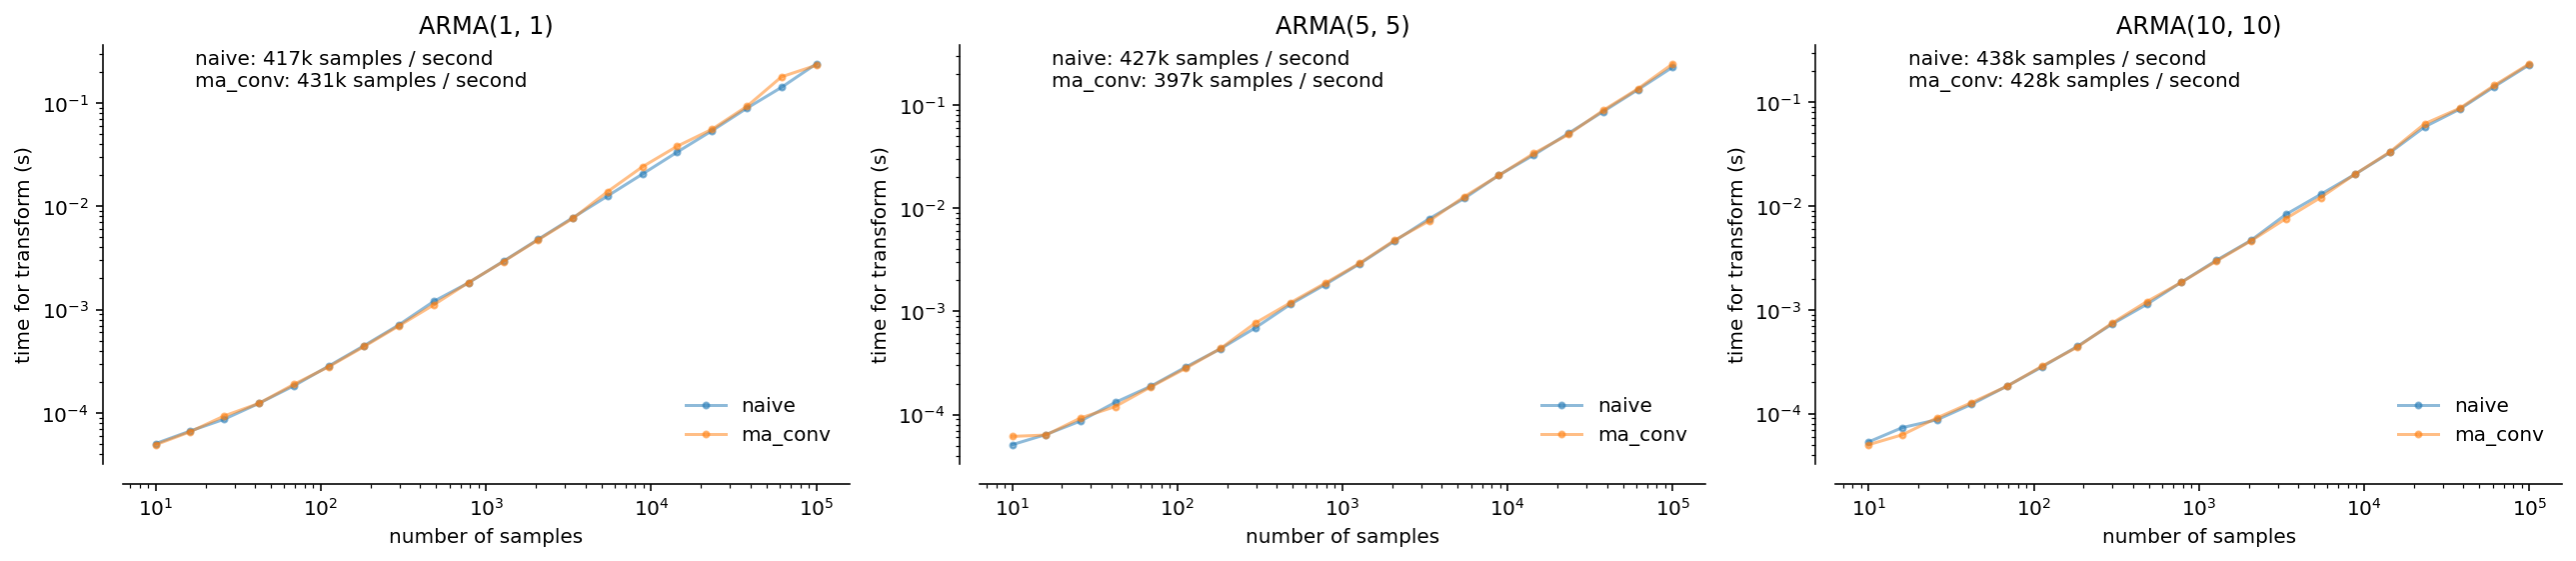

In [19]:
with FigureManager(1, len(spd_params.orders)) as (_, axs):
    for i, ax in enumerate(axs):
        crt_rates = []
        crt_annot_list = []
        for crt_mode in spd_all_modes:
            crt_order = spd_params.orders[i]
            crt_results = spd_results[crt_mode, crt_order]
            ax.loglog(crt_results["sizes"], crt_results["times"], ".-", label=crt_mode, alpha=0.5)

            crt_rate = crt_results["sizes"][-1] / crt_results["times"][-1] / 1000
            crt_rates.append(crt_rate)
            crt_annot_list.append(f"{crt_mode}: {crt_rate:.3g}k samples / second")

        ax.set_title(f"ARMA{crt_order}")
        ax.legend(frameon=False, loc="lower right")
        
        ax.set_xlabel("number of samples")
        ax.set_ylabel("time for transform (s)")

        crt_annot = "\n".join(crt_annot_list)
        ax.annotate(crt_annot, (0.1, 0.9), xycoords="axes fraction")